In [131]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import json

notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
print(sys.path)

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

['/mnt/ceph/users/blyo1/projects', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python310.zip', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/lib-dynload', '', '/mnt/home/blyo1/venvs/py310/lib/python3.10/site-packages', '/tmp/tmppt68cx69']
cuda


# dataset

In [ ]:
# hierarchical dataset 1
from utils.hdisks1 import random_two_disk_dataset
# random sample of disks
data = random_two_disk_dataset(
    delta_id=.2,
    d=10, outer_radius=4, transition_width=2,
    img_size=32, num_imgs=5e4,
    # ib=0.2
)[0]

In [ ]:
# hierarchical dataset 2
from utils.hdisks2 import random_two_disk_dataset

data = random_two_disk_dataset(
    d=10, outer_radius=4, transition_width=2,
    img_size=32, num_imgs=5e4,
)[0]

In [44]:
# hierarchical dataset 3
from utils.hdisks3 import random_two_disk_dataset

data = random_two_disk_dataset(
    img_size=32,
    outer_radius=4,
    transition_width=2,
    d=10,
    num_imgs=5e4
)[0]

In [45]:
from utils.disks import DiskDataset
from torch.utils.data import DataLoader
dataset = DiskDataset(data)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

In [46]:
for batch in dataloader:
    print(batch.shape)
    print(batch.min())
    print(batch.max())
    break

torch.Size([512, 1, 32, 32])
tensor(-0.9997)
tensor(0.9978)


# model 1: VAE

In [40]:
import argparse
from b_models.vae import VariableConvEncoder, VariableConvDecoder, VAE, UNetDecoder

num_channels = 1
image_dims = 32
latent_dims = 10

enc = VariableConvEncoder(
    num_channels,
    image_dims,
    latent_dims, 
    channels=[48, 48], 
    bias=True,
)

dec = VariableConvDecoder(
    num_channels,
    image_dims,
    latent_dims,
    channels=[48, 48],  # output_channels, kernel_size, stride, padding
    output_channels=1,
    bias=True,
)

vae = VAE(
    encoder=enc,
    decoder=dec,
    kl_reduction="mean"
)

# count number of parameters in vae
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f"Number of parameters in VAE: {num_params}")

Number of parameters in VAE: 154197


In [41]:
example_image = torch.randn(1, num_channels, image_dims, image_dims)
# normalize the image to (-1, 1)
example_image = example_image * 2 - 1

vae(example_image)[0].shape

torch.Size([1, 1, 32, 32])

In [ ]:
# now train model
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

vae.train()
vae.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
criterion = nn.MSELoss()
n_epochs = 350

# kl annealing schedule
kl_weight = 0.0
def kl_annealing(epoch, n_epochs_anneal, schedule='linear', end_value = 1.):
    if schedule == 'linear':
        if epoch < n_epochs_anneal:
            kl_weight = end_value * (epoch / n_epochs_anneal)
        else:
            kl_weight = end_value
    elif schedule == 'cosine':
        if epoch < n_epochs_anneal:
            # cosine annealing from 0 to 1
            kl_weight = (1 - 0.5 * (1 + np.cos(np.pi * epoch / n_epochs_anneal))) * end_value
        else:
            kl_weight = end_value
    elif schedule == "constant":
        kl_weight = end_value
    return kl_weight

for epoch in tqdm(range(n_epochs)):
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = vae(batch)[0]
        mse_loss = criterion(output, batch)
        kl_weight = kl_annealing(epoch, 10, schedule='constant', end_value = 1e-7)
        # kl_weight = 1
        kl_loss = vae.kl
        # Combine losses
        loss = mse_loss + kl_loss * kl_weight
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0 or epoch < 10:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, MSE Loss: {mse_loss.item():.4f}, KL weight: {kl_weight:.4f}, KL Loss: {kl_loss.item():.4f}")

  0%|▎                                                                                                              | 1/350 [00:01<06:11,  1.06s/it]

Epoch 1, Loss: 0.0317, MSE Loss: 0.0317, KL weight: 0.0000, KL Loss: 61.0976


  1%|▋                                                                                                              | 2/350 [00:02<06:05,  1.05s/it]

Epoch 2, Loss: 0.0253, MSE Loss: 0.0253, KL weight: 0.0000, KL Loss: 66.6237


  1%|▉                                                                                                              | 3/350 [00:03<06:03,  1.05s/it]

Epoch 3, Loss: 0.0214, MSE Loss: 0.0214, KL weight: 0.0000, KL Loss: 66.3716


  1%|█▎                                                                                                             | 4/350 [00:04<06:00,  1.04s/it]

Epoch 4, Loss: 0.0216, MSE Loss: 0.0216, KL weight: 0.0000, KL Loss: 68.1224


  1%|█▌                                                                                                             | 5/350 [00:05<05:58,  1.04s/it]

Epoch 5, Loss: 0.0177, MSE Loss: 0.0177, KL weight: 0.0000, KL Loss: 67.5525


  2%|█▉                                                                                                             | 6/350 [00:06<05:57,  1.04s/it]

Epoch 6, Loss: 0.0172, MSE Loss: 0.0172, KL weight: 0.0000, KL Loss: 67.8074


  2%|██▏                                                                                                            | 7/350 [00:07<05:56,  1.04s/it]

Epoch 7, Loss: 0.0163, MSE Loss: 0.0163, KL weight: 0.0000, KL Loss: 69.3755


  2%|██▌                                                                                                            | 8/350 [00:08<05:55,  1.04s/it]

Epoch 8, Loss: 0.0158, MSE Loss: 0.0158, KL weight: 0.0000, KL Loss: 71.0103


  3%|██▊                                                                                                            | 9/350 [00:09<05:54,  1.04s/it]

Epoch 9, Loss: 0.0155, MSE Loss: 0.0155, KL weight: 0.0000, KL Loss: 71.1630


  3%|███▏                                                                                                          | 10/350 [00:10<05:53,  1.04s/it]

Epoch 10, Loss: 0.0134, MSE Loss: 0.0134, KL weight: 0.0000, KL Loss: 71.4655


  3%|███▍                                                                                                          | 11/350 [00:11<05:51,  1.04s/it]

Epoch 11, Loss: 0.0118, MSE Loss: 0.0118, KL weight: 0.0000, KL Loss: 72.4529


  6%|██████▌                                                                                                       | 21/350 [00:21<05:42,  1.04s/it]

Epoch 21, Loss: 0.0087, MSE Loss: 0.0087, KL weight: 0.0000, KL Loss: 84.0841


  9%|█████████▋                                                                                                    | 31/350 [00:32<05:33,  1.04s/it]

Epoch 31, Loss: 0.0058, MSE Loss: 0.0058, KL weight: 0.0000, KL Loss: 92.5058


 12%|████████████▉                                                                                                 | 41/350 [00:42<05:23,  1.05s/it]

Epoch 41, Loss: 0.0046, MSE Loss: 0.0046, KL weight: 0.0000, KL Loss: 89.4440


 15%|████████████████                                                                                              | 51/350 [00:53<05:13,  1.05s/it]

Epoch 51, Loss: 0.0046, MSE Loss: 0.0046, KL weight: 0.0000, KL Loss: 93.5131


 17%|███████████████████▏                                                                                          | 61/350 [01:03<05:02,  1.05s/it]

Epoch 61, Loss: 0.0038, MSE Loss: 0.0038, KL weight: 0.0000, KL Loss: 92.6870


 20%|██████████████████████▎                                                                                       | 71/350 [01:14<04:52,  1.05s/it]

Epoch 71, Loss: 0.0041, MSE Loss: 0.0041, KL weight: 0.0000, KL Loss: 93.5085


 23%|█████████████████████████▍                                                                                    | 81/350 [01:24<04:40,  1.04s/it]

Epoch 81, Loss: 0.0034, MSE Loss: 0.0034, KL weight: 0.0000, KL Loss: 89.5672


 26%|████████████████████████████▌                                                                                 | 91/350 [01:35<04:29,  1.04s/it]

Epoch 91, Loss: 0.0032, MSE Loss: 0.0032, KL weight: 0.0000, KL Loss: 95.4365


 29%|███████████████████████████████▍                                                                             | 101/350 [01:45<04:20,  1.04s/it]

Epoch 101, Loss: 0.0035, MSE Loss: 0.0035, KL weight: 0.0000, KL Loss: 93.3024


 32%|██████████████████████████████████▌                                                                          | 111/350 [01:55<04:09,  1.04s/it]

Epoch 111, Loss: 0.0033, MSE Loss: 0.0033, KL weight: 0.0000, KL Loss: 94.1823


 35%|█████████████████████████████████████▋                                                                       | 121/350 [02:06<03:58,  1.04s/it]

Epoch 121, Loss: 0.0031, MSE Loss: 0.0031, KL weight: 0.0000, KL Loss: 92.1302


 37%|████████████████████████████████████████▊                                                                    | 131/350 [02:16<03:49,  1.05s/it]

Epoch 131, Loss: 0.0066, MSE Loss: 0.0066, KL weight: 0.0000, KL Loss: 86.9862


 40%|███████████████████████████████████████████▉                                                                 | 141/350 [02:27<03:36,  1.04s/it]

Epoch 141, Loss: 0.0030, MSE Loss: 0.0030, KL weight: 0.0000, KL Loss: 92.4776


 43%|███████████████████████████████████████████████                                                              | 151/350 [02:37<03:26,  1.04s/it]

Epoch 151, Loss: 0.0032, MSE Loss: 0.0032, KL weight: 0.0000, KL Loss: 95.3664


 46%|██████████████████████████████████████████████████▏                                                          | 161/350 [02:47<03:16,  1.04s/it]

Epoch 161, Loss: 0.0028, MSE Loss: 0.0028, KL weight: 0.0000, KL Loss: 90.3689


 49%|█████████████████████████████████████████████████████▎                                                       | 171/350 [02:58<03:06,  1.04s/it]

Epoch 171, Loss: 0.0028, MSE Loss: 0.0027, KL weight: 0.0000, KL Loss: 89.5386


 52%|████████████████████████████████████████████████████████▎                                                    | 181/350 [03:08<02:56,  1.05s/it]

Epoch 181, Loss: 0.0029, MSE Loss: 0.0029, KL weight: 0.0000, KL Loss: 94.5832


 55%|███████████████████████████████████████████████████████████▍                                                 | 191/350 [03:19<02:45,  1.04s/it]

Epoch 191, Loss: 0.0029, MSE Loss: 0.0029, KL weight: 0.0000, KL Loss: 91.0843


 57%|██████████████████████████████████████████████████████████████▌                                              | 201/350 [03:29<02:36,  1.05s/it]

Epoch 201, Loss: 0.0030, MSE Loss: 0.0030, KL weight: 0.0000, KL Loss: 92.0624


 60%|█████████████████████████████████████████████████████████████████▋                                           | 211/350 [03:40<02:25,  1.05s/it]

Epoch 211, Loss: 0.0027, MSE Loss: 0.0027, KL weight: 0.0000, KL Loss: 93.8242


 63%|████████████████████████████████████████████████████████████████████▊                                        | 221/350 [03:50<02:15,  1.05s/it]

Epoch 221, Loss: 0.0026, MSE Loss: 0.0026, KL weight: 0.0000, KL Loss: 91.2640


 66%|███████████████████████████████████████████████████████████████████████▉                                     | 231/350 [04:01<02:04,  1.05s/it]

Epoch 231, Loss: 0.0022, MSE Loss: 0.0022, KL weight: 0.0000, KL Loss: 88.5904


 69%|███████████████████████████████████████████████████████████████████████████                                  | 241/350 [04:11<01:53,  1.04s/it]

Epoch 241, Loss: 0.0026, MSE Loss: 0.0026, KL weight: 0.0000, KL Loss: 92.9475


 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 251/350 [04:21<01:42,  1.04s/it]

Epoch 251, Loss: 0.0030, MSE Loss: 0.0030, KL weight: 0.0000, KL Loss: 94.8214


 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 261/350 [04:32<01:32,  1.04s/it]

Epoch 261, Loss: 0.0025, MSE Loss: 0.0025, KL weight: 0.0000, KL Loss: 91.7184


 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 271/350 [04:42<01:21,  1.03s/it]

Epoch 271, Loss: 0.0022, MSE Loss: 0.0022, KL weight: 0.0000, KL Loss: 87.6777


 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 281/350 [04:53<01:11,  1.04s/it]

Epoch 281, Loss: 0.0025, MSE Loss: 0.0025, KL weight: 0.0000, KL Loss: 88.2080


 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 291/350 [05:03<01:01,  1.04s/it]

Epoch 291, Loss: 0.0025, MSE Loss: 0.0025, KL weight: 0.0000, KL Loss: 90.6830


 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 301/350 [05:13<00:51,  1.04s/it]

Epoch 301, Loss: 0.0024, MSE Loss: 0.0024, KL weight: 0.0000, KL Loss: 85.3140


 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 311/350 [05:24<00:40,  1.04s/it]

Epoch 311, Loss: 0.0024, MSE Loss: 0.0024, KL weight: 0.0000, KL Loss: 88.4501


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 321/350 [05:34<00:30,  1.04s/it]

Epoch 321, Loss: 0.0021, MSE Loss: 0.0021, KL weight: 0.0000, KL Loss: 84.5179


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 331/350 [05:45<00:19,  1.05s/it]

Epoch 331, Loss: 0.0025, MSE Loss: 0.0025, KL weight: 0.0000, KL Loss: 90.5955


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 341/350 [05:55<00:09,  1.05s/it]

Epoch 341, Loss: 0.0024, MSE Loss: 0.0024, KL weight: 0.0000, KL Loss: 88.1281


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [06:05<00:00,  1.04s/it]


In [ ]:
# save model
mode = 'save'
dataset_v = '3'
model_v = '3'

save_dir = "./b_models/saved_weights"
if mode == "save":
    torch.save(vae.state_dict(), os.path.join(save_dir, f'vae-dataset_{dataset_v}-model_{model_v}.pth'))
elif mode == "load":
    vae.load_state_dict(torch.load(os.path.join(save_dir, f'vae-dataset_{dataset_v}-model_{model_v}.pth')))

tensor(-0.6306) tensor(-0.7460) tensor(0.5964) tensor(0.7190)
Test Loss: 0.0018


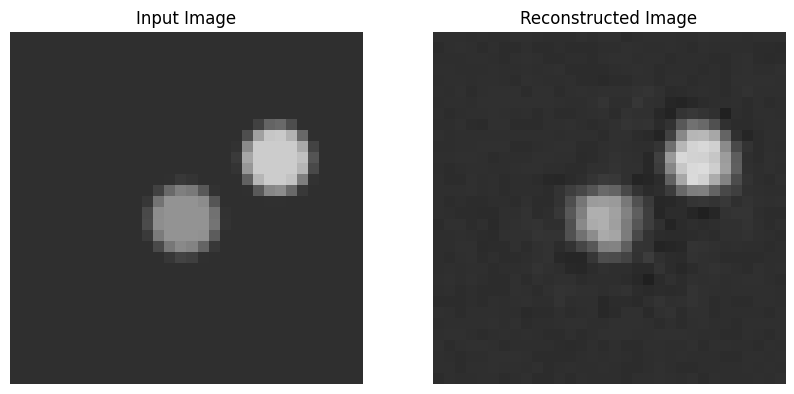

In [ ]:
from utils.base_utils import to_01, to_0c
img_idx = 11

test_img = to_0c(data[img_idx]).unsqueeze(1).to(device)

vae.eval()
xout, xin = vae(test_img)[0:2]
xout = xout.detach().cpu()
xin = xin.detach().cpu()

print(xin.min(), xout.min(), xin.max(), xout.max())
test_loss = criterion(xin, xout).item()
print(f"Test Loss: {test_loss:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(to_01(xin).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[0].set_title("Input Image")
ax[0].axis("off");

ax[1].imshow(to_01(xout).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[1].set_title("Reconstructed Image")
ax[1].axis("off");



tensor(-0.9473) tensor(-1.2000) tensor(0.9767) tensor(1.1271)
Test Loss: 0.0045


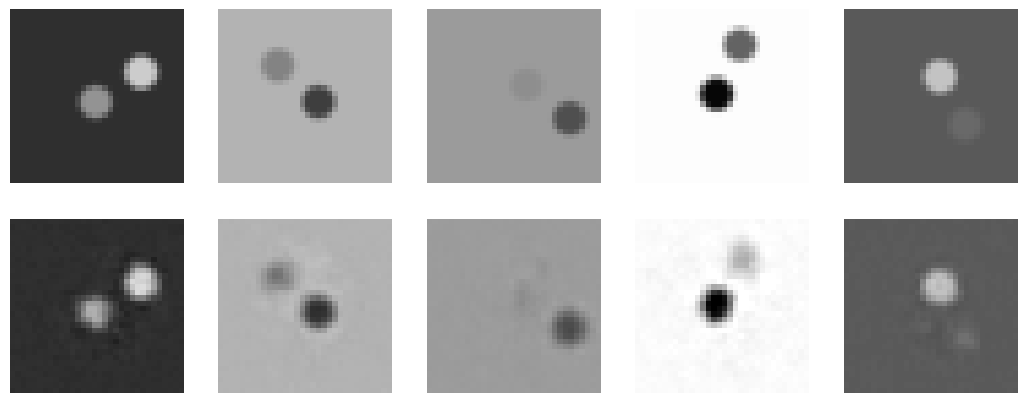

In [ ]:
from utils.base_utils import to_01, to_0c
test_img = to_0c(data[11:16]).to(device)

vae.eval()
out = vae(test_img)
xout = out[0]
xin = out[1]
xout = xout.detach().cpu()
xin = xin.detach().cpu()

print(xin.min(), xout.min(), xin.max(), xout.max())
test_loss = criterion(xin, xout).item()
print(f"Test Loss: {test_loss:.4f}")

fig, ax = plt.subplots(2, len(test_img), figsize=(13, 5))
for i in range(len(test_img)):
    ax[0, i].imshow(to_01(xin[i]).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
    # ax[0, i].set_title("Input Image")
    ax[0, i].axis("off");

    ax[1, i].imshow(to_01(xout[i]).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
    # ax[1, i].set_title("Reconstructed Image")
    ax[1, i].axis("off");


# model 2: spatial VAE

In [97]:
from b_models.vae2 import SpatialConvEncoder, SpatialConvDecoder, VAE

z_dim = 10
channels = [32, 32]

encoder = SpatialConvEncoder(input_dim=32, z_dim=z_dim, c_in=1, channels=channels)
decoder = SpatialConvDecoder(output_dim=32, z_dim=z_dim, c_out=1, channels=channels)
vae = VAE(encoder, decoder)

In [98]:
print(vae.decoder.deconv_network)

Sequential(
  (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [99]:
test_img = torch.randn((1, 1, 32, 32))

vae(test_img)[0].shape

torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 8, 8])
torch.Size([1, 10])
torch.Size([1, 10, 1, 1])
torch.Size([1, 32, 8, 8])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])
torch.Size([1, 32, 16, 16])


torch.Size([1, 1, 32, 32])

# model 3: vae based on LVAE
using the same codebase as the LVAE code so as to maintain parity

In [ ]:
from b_models.vae3 import VAE
test_img = torch.randn((1, 1, 32, 32))
channels = [1, 32, 32]
vae = VAE(input_dim=32, z_dim=10, channels=channels, num_blocks=2)
out = vae(test_img)

from utils.base_utils import count_parameters
print(count_parameters(vae))

print(out.shape)

torch.Size([1, 1, 32, 32])


In [ ]:
# now train model
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

vae.train()
vae.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
criterion = nn.MSELoss()
n_epochs = 350

# kl annealing schedule
kl_weight = 0.0
def kl_annealing(epoch, n_epochs_anneal, schedule='linear', end_value = 1.):
    if schedule == 'linear':
        if epoch < n_epochs_anneal:
            kl_weight = end_value * (epoch / n_epochs_anneal)
        else:
            kl_weight = end_value
    elif schedule == 'cosine':
        if epoch < n_epochs_anneal:
            # cosine annealing from 0 to 1
            kl_weight = (1 - 0.5 * (1 + np.cos(np.pi * epoch / n_epochs_anneal))) * end_value
        else:
            kl_weight = end_value
    elif schedule == "constant":
        kl_weight = end_value
    return kl_weight

for epoch in tqdm(range(n_epochs)):
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = vae(batch)
        mse_loss = criterion(output, batch)
        kl_weight = kl_annealing(epoch, 10, schedule='constant', end_value = 1e-7)
        # kl_weight = 1
        kl_loss = vae.kl
        # Combine losses
        loss = mse_loss + kl_loss * kl_weight
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0 or epoch < 10:
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, MSE Loss: {mse_loss.item():.4f}, KL weight: {kl_weight:.4f}, KL Loss: {kl_loss.item():.4f}")

from utils.base_utils import count_parameters
print(count_parameters(vae))

  0%|▎                                                                                                              | 1/350 [00:01<09:44,  1.67s/it]

Epoch 1, Loss: 0.1250, MSE Loss: 0.1250, KL weight: 0.0000, KL Loss: 61.4289


  1%|▋                                                                                                              | 2/350 [00:02<08:21,  1.44s/it]

Epoch 2, Loss: 0.0943, MSE Loss: 0.0943, KL weight: 0.0000, KL Loss: 89.7447


  1%|▉                                                                                                              | 3/350 [00:04<07:54,  1.37s/it]

Epoch 3, Loss: 0.0816, MSE Loss: 0.0815, KL weight: 0.0000, KL Loss: 116.5520


  1%|█▎                                                                                                             | 4/350 [00:05<07:40,  1.33s/it]

Epoch 4, Loss: 0.0733, MSE Loss: 0.0733, KL weight: 0.0000, KL Loss: 122.7354


  1%|█▌                                                                                                             | 5/350 [00:06<07:32,  1.31s/it]

Epoch 5, Loss: 0.0607, MSE Loss: 0.0607, KL weight: 0.0000, KL Loss: 124.7035


  2%|█▉                                                                                                             | 6/350 [00:08<07:26,  1.30s/it]

Epoch 6, Loss: 0.0584, MSE Loss: 0.0584, KL weight: 0.0000, KL Loss: 119.3733


  2%|██▏                                                                                                            | 7/350 [00:09<07:22,  1.29s/it]

Epoch 7, Loss: 0.0565, MSE Loss: 0.0565, KL weight: 0.0000, KL Loss: 116.8165


  2%|██▌                                                                                                            | 8/350 [00:10<07:19,  1.29s/it]

Epoch 8, Loss: 0.0557, MSE Loss: 0.0557, KL weight: 0.0000, KL Loss: 123.1346


  3%|██▊                                                                                                            | 9/350 [00:11<07:17,  1.28s/it]

Epoch 9, Loss: 0.0517, MSE Loss: 0.0517, KL weight: 0.0000, KL Loss: 121.4904


  3%|███▏                                                                                                          | 10/350 [00:13<07:15,  1.28s/it]

Epoch 10, Loss: 0.0480, MSE Loss: 0.0480, KL weight: 0.0000, KL Loss: 124.8179


  3%|███▍                                                                                                          | 11/350 [00:14<07:13,  1.28s/it]

Epoch 11, Loss: 0.0481, MSE Loss: 0.0481, KL weight: 0.0000, KL Loss: 128.6965


  6%|██████▌                                                                                                       | 21/350 [00:27<06:58,  1.27s/it]

Epoch 21, Loss: 0.0427, MSE Loss: 0.0427, KL weight: 0.0000, KL Loss: 83.6554


  9%|█████████▋                                                                                                    | 31/350 [00:39<06:47,  1.28s/it]

Epoch 31, Loss: 0.0234, MSE Loss: 0.0234, KL weight: 0.0000, KL Loss: 58.9332


 12%|████████████▉                                                                                                 | 41/350 [00:52<06:35,  1.28s/it]

Epoch 41, Loss: 0.0137, MSE Loss: 0.0137, KL weight: 0.0000, KL Loss: 62.2695


 15%|████████████████                                                                                              | 51/350 [01:05<06:22,  1.28s/it]

Epoch 51, Loss: 0.0153, MSE Loss: 0.0153, KL weight: 0.0000, KL Loss: 63.1567


 17%|███████████████████▏                                                                                          | 61/350 [01:18<06:08,  1.28s/it]

Epoch 61, Loss: 0.0095, MSE Loss: 0.0094, KL weight: 0.0000, KL Loss: 65.4404


 20%|██████████████████████▎                                                                                       | 71/350 [01:30<05:55,  1.27s/it]

Epoch 71, Loss: 0.0085, MSE Loss: 0.0085, KL weight: 0.0000, KL Loss: 66.7330


 23%|█████████████████████████▍                                                                                    | 81/350 [01:43<05:41,  1.27s/it]

Epoch 81, Loss: 0.0076, MSE Loss: 0.0075, KL weight: 0.0000, KL Loss: 66.8691


 26%|████████████████████████████▌                                                                                 | 91/350 [01:56<05:29,  1.27s/it]

Epoch 91, Loss: 0.0076, MSE Loss: 0.0076, KL weight: 0.0000, KL Loss: 67.5947


 29%|███████████████████████████████▍                                                                             | 101/350 [02:09<05:16,  1.27s/it]

Epoch 101, Loss: 0.0069, MSE Loss: 0.0069, KL weight: 0.0000, KL Loss: 69.1630


 32%|██████████████████████████████████▌                                                                          | 111/350 [02:21<05:06,  1.28s/it]

Epoch 111, Loss: 0.0068, MSE Loss: 0.0068, KL weight: 0.0000, KL Loss: 69.2810


 35%|█████████████████████████████████████▋                                                                       | 121/350 [02:34<04:52,  1.28s/it]

Epoch 121, Loss: 0.0077, MSE Loss: 0.0077, KL weight: 0.0000, KL Loss: 69.5350


 37%|████████████████████████████████████████▊                                                                    | 131/350 [02:47<04:39,  1.28s/it]

Epoch 131, Loss: 0.0073, MSE Loss: 0.0073, KL weight: 0.0000, KL Loss: 70.2928


 40%|███████████████████████████████████████████▉                                                                 | 141/350 [03:00<04:26,  1.28s/it]

Epoch 141, Loss: 0.0058, MSE Loss: 0.0057, KL weight: 0.0000, KL Loss: 70.0380


 43%|███████████████████████████████████████████████                                                              | 151/350 [03:12<04:14,  1.28s/it]

Epoch 151, Loss: 0.0067, MSE Loss: 0.0067, KL weight: 0.0000, KL Loss: 70.8356


 46%|██████████████████████████████████████████████████▏                                                          | 161/350 [03:25<04:01,  1.28s/it]

Epoch 161, Loss: 0.0067, MSE Loss: 0.0067, KL weight: 0.0000, KL Loss: 70.9134


 49%|█████████████████████████████████████████████████████▎                                                       | 171/350 [03:38<03:47,  1.27s/it]

Epoch 171, Loss: 0.0061, MSE Loss: 0.0061, KL weight: 0.0000, KL Loss: 71.7099


 52%|████████████████████████████████████████████████████████▎                                                    | 181/350 [03:51<03:34,  1.27s/it]

Epoch 181, Loss: 0.0054, MSE Loss: 0.0054, KL weight: 0.0000, KL Loss: 71.1215


 55%|███████████████████████████████████████████████████████████▍                                                 | 191/350 [04:03<03:22,  1.28s/it]

Epoch 191, Loss: 0.0054, MSE Loss: 0.0054, KL weight: 0.0000, KL Loss: 71.4944


 57%|██████████████████████████████████████████████████████████████▌                                              | 201/350 [04:16<03:09,  1.27s/it]

Epoch 201, Loss: 0.0052, MSE Loss: 0.0052, KL weight: 0.0000, KL Loss: 71.5326


 60%|█████████████████████████████████████████████████████████████████▋                                           | 211/350 [04:29<02:56,  1.27s/it]

Epoch 211, Loss: 0.0050, MSE Loss: 0.0050, KL weight: 0.0000, KL Loss: 71.0168


 63%|████████████████████████████████████████████████████████████████████▊                                        | 221/350 [04:41<02:43,  1.27s/it]

Epoch 221, Loss: 0.0065, MSE Loss: 0.0065, KL weight: 0.0000, KL Loss: 72.4948


 66%|███████████████████████████████████████████████████████████████████████▉                                     | 231/350 [04:54<02:31,  1.27s/it]

Epoch 231, Loss: 0.0050, MSE Loss: 0.0050, KL weight: 0.0000, KL Loss: 72.0680


 69%|███████████████████████████████████████████████████████████████████████████                                  | 241/350 [05:07<02:19,  1.28s/it]

Epoch 241, Loss: 0.0065, MSE Loss: 0.0065, KL weight: 0.0000, KL Loss: 71.8168


 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 251/350 [05:20<02:06,  1.28s/it]

Epoch 251, Loss: 0.0051, MSE Loss: 0.0051, KL weight: 0.0000, KL Loss: 72.6166


 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 261/350 [05:32<01:53,  1.27s/it]

Epoch 261, Loss: 0.0051, MSE Loss: 0.0051, KL weight: 0.0000, KL Loss: 72.1139


 77%|████████████████████████████████████████████████████████████████████████████████████▍                        | 271/350 [05:45<01:40,  1.27s/it]

Epoch 271, Loss: 0.0049, MSE Loss: 0.0048, KL weight: 0.0000, KL Loss: 72.8617


 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 281/350 [05:58<01:27,  1.27s/it]

Epoch 281, Loss: 0.0045, MSE Loss: 0.0045, KL weight: 0.0000, KL Loss: 72.3690


 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 291/350 [06:11<01:14,  1.27s/it]

Epoch 291, Loss: 0.0062, MSE Loss: 0.0062, KL weight: 0.0000, KL Loss: 72.1450


 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 301/350 [06:23<01:02,  1.27s/it]

Epoch 301, Loss: 0.0056, MSE Loss: 0.0056, KL weight: 0.0000, KL Loss: 71.5021


 89%|████████████████████████████████████████████████████████████████████████████████████████████████▊            | 311/350 [06:36<00:49,  1.27s/it]

Epoch 311, Loss: 0.0050, MSE Loss: 0.0050, KL weight: 0.0000, KL Loss: 73.3222


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉         | 321/350 [06:49<00:37,  1.28s/it]

Epoch 321, Loss: 0.0042, MSE Loss: 0.0042, KL weight: 0.0000, KL Loss: 73.1563


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 331/350 [07:02<00:24,  1.28s/it]

Epoch 331, Loss: 0.0044, MSE Loss: 0.0044, KL weight: 0.0000, KL Loss: 73.6174


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 341/350 [07:14<00:11,  1.28s/it]

Epoch 341, Loss: 0.0043, MSE Loss: 0.0043, KL weight: 0.0000, KL Loss: 73.4838


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [07:26<00:00,  1.28s/it]


In [53]:
# save model
mode = 'save'
dataset_v = '3'
model_v = '3'
experiment = '1'

save_dir = "./b_models/saved_weights"
if mode == "save":
    torch.save(vae.state_dict(), os.path.join(save_dir, f'vae-dataset_{dataset_v}-model_{model_v}-exp_{experiment}.pth'))
    config = {
        "n_epochs": n_epochs,
        "kl_schedule": "constant",
        "kl_weight": 1e-7,
        "lr": 1e-3,
        "z_dim": 10,
        "channels": channels
        }
    json.dump(config, open(os.path.join(save_dir, f'vae-dataset_{dataset_v}-model_{model_v}-exp_{experiment}_config.json'), 'w'))
elif mode == "load":
    vae.load_state_dict(torch.load(os.path.join(save_dir, f'vae-dataset_{dataset_v}-model_{model_v}-exp_{experiment}.pth')))

tensor(-0.5912) tensor(-0.7864) tensor(0.3253) tensor(0.4610)
Test Loss: 0.0024


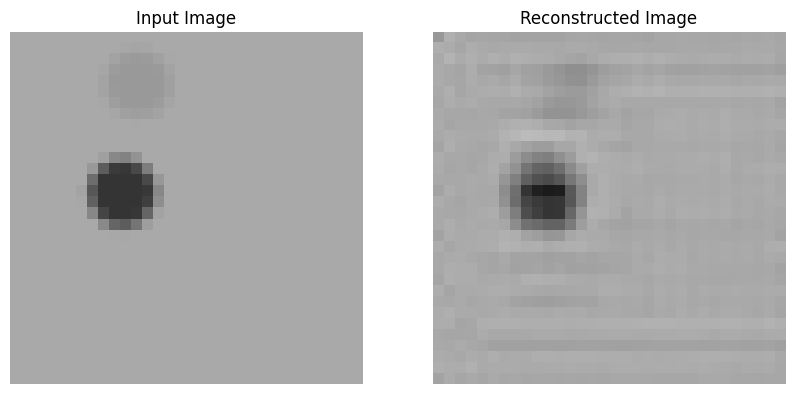

In [54]:
from utils.base_utils import to_01, to_0c
img_idx = 11

test_img = to_0c(data[img_idx]).unsqueeze(1).to(device)

vae.eval()
xout = vae(test_img)[0:2]
xout = xout.detach().cpu()
xin = test_img.cpu()

print(xin.min(), xout.min(), xin.max(), xout.max())
test_loss = criterion(xin, xout).item()
print(f"Test Loss: {test_loss:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(to_01(xin).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[0].set_title("Input Image")
ax[0].axis("off");

ax[1].imshow(to_01(xout).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
ax[1].set_title("Reconstructed Image")
ax[1].axis("off");



tensor(-0.7421) tensor(-0.9126) tensor(0.7639) tensor(1.0894)
Test Loss: 0.0029


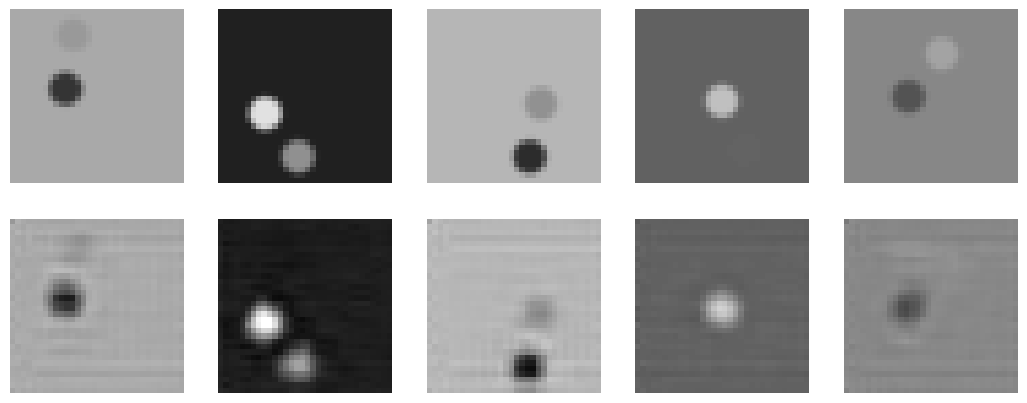

In [55]:
from utils.base_utils import to_01, to_0c
test_img = to_0c(data[11:16]).to(device)

vae.eval()
out = vae(test_img)
xout = out
xout = xout.detach().cpu()
xin = test_img.cpu()

print(xin.min(), xout.min(), xin.max(), xout.max())
test_loss = criterion(xin, xout).item()
print(f"Test Loss: {test_loss:.4f}")

fig, ax = plt.subplots(2, len(test_img), figsize=(13, 5))
for i in range(len(test_img)):
    ax[0, i].imshow(to_01(xin[i]).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
    # ax[0, i].set_title("Input Image")
    ax[0, i].axis("off");

    ax[1, i].imshow(to_01(xout[i]).squeeze(0, 1), cmap="gray", vmin=0, vmax=1)
    # ax[1, i].set_title("Reconstructed Image")
    ax[1, i].axis("off");


# analysis

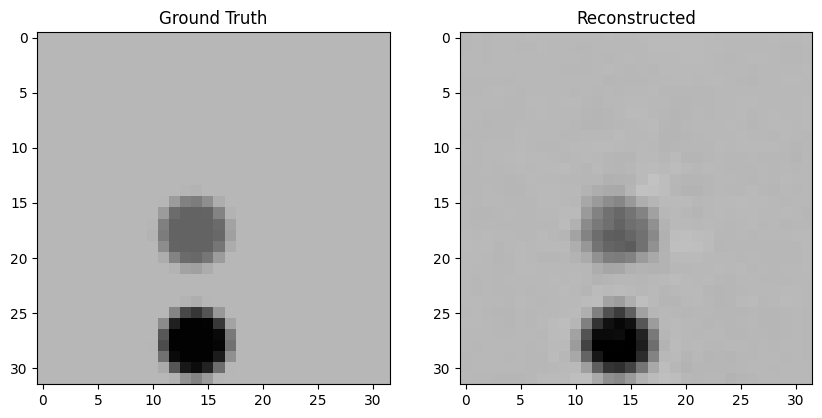

[[5 2 0 1 3 4]]


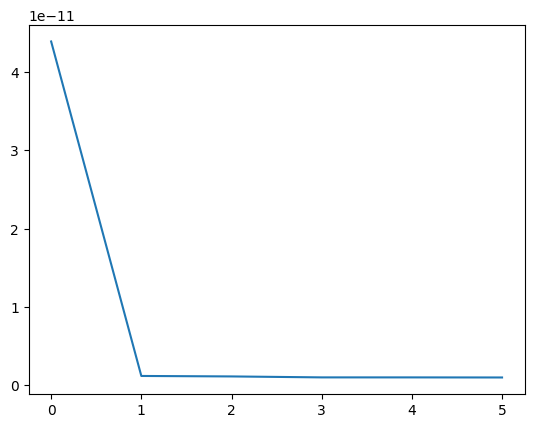

In [ ]:
img_idx = 12

test_img = to_0c(data[img_idx]).unsqueeze(1).to(device)

xhat_base = vae(test_img)[0]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(to_01(test_img).squeeze(0, 1).cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
ax[0].set_title('Ground Truth')
ax[1].imshow(to_01(xhat_base).squeeze(0, 1).cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
ax[1].set_title('Reconstructed')
plt.show()

z, mu, cov = vae.encoder(test_img)
cov = cov.detach().cpu().numpy()
cov_sort = np.flip(np.sort(cov, axis=1))
# get argsort
cov_argsort = np.flip(np.argsort(cov, axis=1))

fig, ax = plt.subplots(1, 1)
ax.plot(cov_sort.squeeze(0))
print(cov_argsort)

In [ ]:
# now perturb along one axis and see what the decoded images look like
mu_base = mu.clone()
perturbations = np.linspace(-1, 1, 11)  # perturbations from -1 to 1 in 10 steps
perturbed_mus = torch.empty((len(perturbations), mu.shape[1])).to(device)

variance_mode = 0  # the index of the nth largest variance
for j in range(len(perturbations)):
    perturbed_mu = mu_base.clone()
    perturbed_mu[:, cov_argsort[0, variance_mode]] += perturbations[j]  # perturb by delta * 0.1 along the j-th axis
    perturbed_mus[j] = perturbed_mu.squeeze(0)

xhat_perturb = vae.decoder(perturbed_mus).squeeze(1)
print(xhat_perturb.shape)


torch.Size([11, 32, 32])


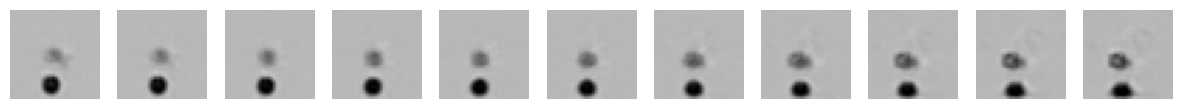

In [ ]:
fig, ax = plt.subplots(1, len(perturbations), figsize=(15, 5))
for j in range(len(perturbations)):
    ax[j].imshow(to_01(xhat_perturb[j]).cpu().detach().numpy(), vmin=0, vmax=1, cmap='gray')
    ax[j].axis('off')
plt.show()
